In [20]:
from datetime import datetime
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from peewee import *
from pprint import pprint

In [21]:
run = "run-04"
guestbook_json = json.load(open(f"{run}/guestbook.json"))
hosts_json = json.load(open(f"{run}/hosts.json"))

```
  {
    "content_length": null,
    "content_sha1": null,
    "content_type": null,
    "host": 137161,
    "id": 514973,
    "last_fetched": "2024-11-27T14:39:29.114186Z",
    "last_updated": "2024-11-26T08:38:54Z",
    "next_fetch": "2024-12-04T14:39:32.112951Z",
    "path": "/",
    "scheme": "https"
  },
```

In [22]:
try:
    os.remove(f"{run}/analysis.sqlite")
except:
    pass

db = SqliteDatabase(f'{run}/analysis.sqlite')

# {"host":"www.genome.gov","id":137136,"next_fetch":"2024-12-27T15:26:43.918709Z"}
class Hosts(Model):
    host = TextField()
    id = IntegerField(primary_key=True)
    next_fetch = DateField()
    class Meta:
        database = db

class GB(Model):
    content_length = IntegerField(null=True)
    content_sha1 = TextField(null=True)
    content_type = TextField(null=True)
    host = ForeignKeyField(Hosts, 'id')
    id = IntegerField()
    last_fetched = DateField()
    last_updated = DateField()
    next_fetch = DateField()
    path = TextField()
    scheme = TextField()
    class Meta:
        database = db

In [23]:
db.connect()
db.create_tables([GB, Hosts])

In [24]:
# Takes around 30s
with db.atomic():
    for batch in chunked(hosts_json, 100):
        Hosts.insert_many(hosts_json).execute()
with db.atomic():
    for batch in chunked(guestbook_json, 100):
        GB.insert_many(batch).execute()


In [25]:
# Start by going one host at a time
gbq = (GB.select(fn.Distinct(GB.host)))
counting = dict()
for uniq_gb in gbq:
    host = uniq_gb.host.host
    # Count the entries in each host
    counting[host] = GB.select().where(GB.host == uniq_gb.host).count()

df = pd.DataFrame(counting.items(), columns=['host', 'count'])   
print(df.sort_values(by='count').to_markdown())

|    | host              |   count |
|---:|:------------------|--------:|
| 17 | public.csr.nih.go |       1 |
| 16 | www.cit.nih.gov   |      42 |
|  1 | www.nia.nih.gov   |     159 |
| 14 | www.ninds.nih.gov |     179 |
|  8 | www.niaid.nih.gov |     229 |
|  4 | www.ninr.nih.gov  |     449 |
| 18 | ncats.nih.gov     |     903 |
| 19 | www.nidcr.nih.gov |    1079 |
| 22 | www.nibib.nih.gov |    1210 |
|  2 | www.nigms.nih.gov |    1555 |
| 23 | www.cc.nih.gov    |    2017 |
| 15 | www.niaaa.nih.gov |    2177 |
| 24 | www.nccih.nih.gov |    2296 |
| 21 | www.niams.nih.gov |    2305 |
|  6 | www.fic.nih.gov   |    2519 |
|  7 | www.nei.nih.gov   |    2634 |
| 11 | nida.nih.gov      |    2973 |
| 13 | www.nimhd.nih.gov |    3841 |
|  3 | www.nimh.nih.gov  |    5409 |
| 10 | www.niddk.nih.gov |    6439 |
| 20 | www.nhlbi.nih.gov |    7188 |
|  9 | www.nichd.nih.gov |    7239 |
| 12 | www.niehs.nih.gov |    7497 |
|  0 | www.genome.gov    |    7646 |
| 25 | www.cancer.gov    |   10383 |
|

Q: How long did all of these fetches take?

A: One answer is from the first "last_fetched" until the last "last_fetched"

Q: Is that an accurate measure?

A: Yes, and no. No, because it asks what the largest domain is, and how long that took. That is, a large domain can only fetch one page per 2s, so that means the total duration is that of nlm.nih.gov.

Q: What is a more accurate measure?

A: What is the first and last fetch for each domain?

Q: Is that more accurate?

A: ... yes? It measures how long things take to get through the queue as well. So, it is *authentic*.

In [26]:
def seconds_between(d1, d2):
    d1 = datetime.strptime(d1, "%Y-%m-%dT%H:%M:%S.%fZ")
    d2 = datetime.strptime(d2, "%Y-%m-%dT%H:%M:%S.%fZ")
    diff = abs((d2 - d1))
    # Don't allow zero values.
    # Easiest to pad the value by one second.
    return diff.seconds+1

gbq = (GB.select(fn.Distinct(GB.host)))
first_last = dict()
for uniq_gb in gbq:
    host_id = uniq_gb.host
    host_name = uniq_gb.host.host
    earliest_fetch = GB.select(fn.MIN(GB.last_fetched)).where(GB.host == host_id).scalar()
    last_fetch = GB.select(fn.MAX(GB.last_fetched)).where(GB.host == host_id).scalar()
    first_last[host_name] = seconds_between(earliest_fetch, last_fetch)

df = pd.DataFrame(first_last.items(), columns=['host', 'seconds'])

for index, row in df.iterrows():
    if row['seconds'] < 10:
        df.drop(index, inplace=True)
    else:
        df.loc[index, 'pages'] = counting[row['host']]
        df.loc[index, 'ppm'] = counting[row['host']] / (row['seconds']/60)
    
print(df.sort_values(by='host').to_markdown())

|    | host              |   seconds |   pages |       ppm |
|---:|:------------------|----------:|--------:|----------:|
| 18 | ncats.nih.gov     |      9583 |     903 |  5.65376  |
| 11 | nida.nih.gov      |     16578 |    2973 | 10.76     |
| 25 | www.cancer.gov    |     22340 |   10383 | 27.8863   |
| 23 | www.cc.nih.gov    |     12995 |    2017 |  9.31281  |
| 16 | www.cit.nih.gov   |      1499 |      42 |  1.68112  |
|  6 | www.fic.nih.gov   |      8449 |    2519 | 17.8885   |
|  0 | www.genome.gov    |     17648 |    7646 | 25.995    |
| 24 | www.nccih.nih.gov |     15251 |    2296 |  9.03285  |
|  7 | www.nei.nih.gov   |      7846 |    2634 | 20.1427   |
| 20 | www.nhlbi.nih.gov |     16220 |    7188 | 26.5894   |
|  1 | www.nia.nih.gov   |     37572 |     159 |  0.253912 |
| 15 | www.niaaa.nih.gov |      7904 |    2177 | 16.5258   |
|  8 | www.niaid.nih.gov |     37757 |     229 |  0.363906 |
| 21 | www.niams.nih.gov |     37761 |    2305 |  3.66251  |
| 22 | www.nibib.nih.gov

137136 www.genome.gov
137137 www.nia.nih.gov
137138 www.nigms.nih.gov
137139 www.nimh.nih.gov
137140 www.ninr.nih.gov
137141 www.nlm.nih.gov
137142 www.fic.nih.gov
137143 www.nei.nih.gov
137144 www.niaid.nih.gov
137145 www.nichd.nih.gov
137146 www.niddk.nih.gov
137147 nida.nih.gov
137148 www.niehs.nih.gov
137149 www.nimhd.nih.gov
137150 www.ninds.nih.gov
137151 www.niaaa.nih.gov
137152 www.cit.nih.gov
137153 public.csr.nih.go
137154 ncats.nih.gov
137155 www.nidcr.nih.gov
137156 www.nhlbi.nih.gov
137157 www.niams.nih.gov
137158 www.nibib.nih.gov
137159 www.cc.nih.gov
137160 www.nccih.nih.gov
137161 www.cancer.gov


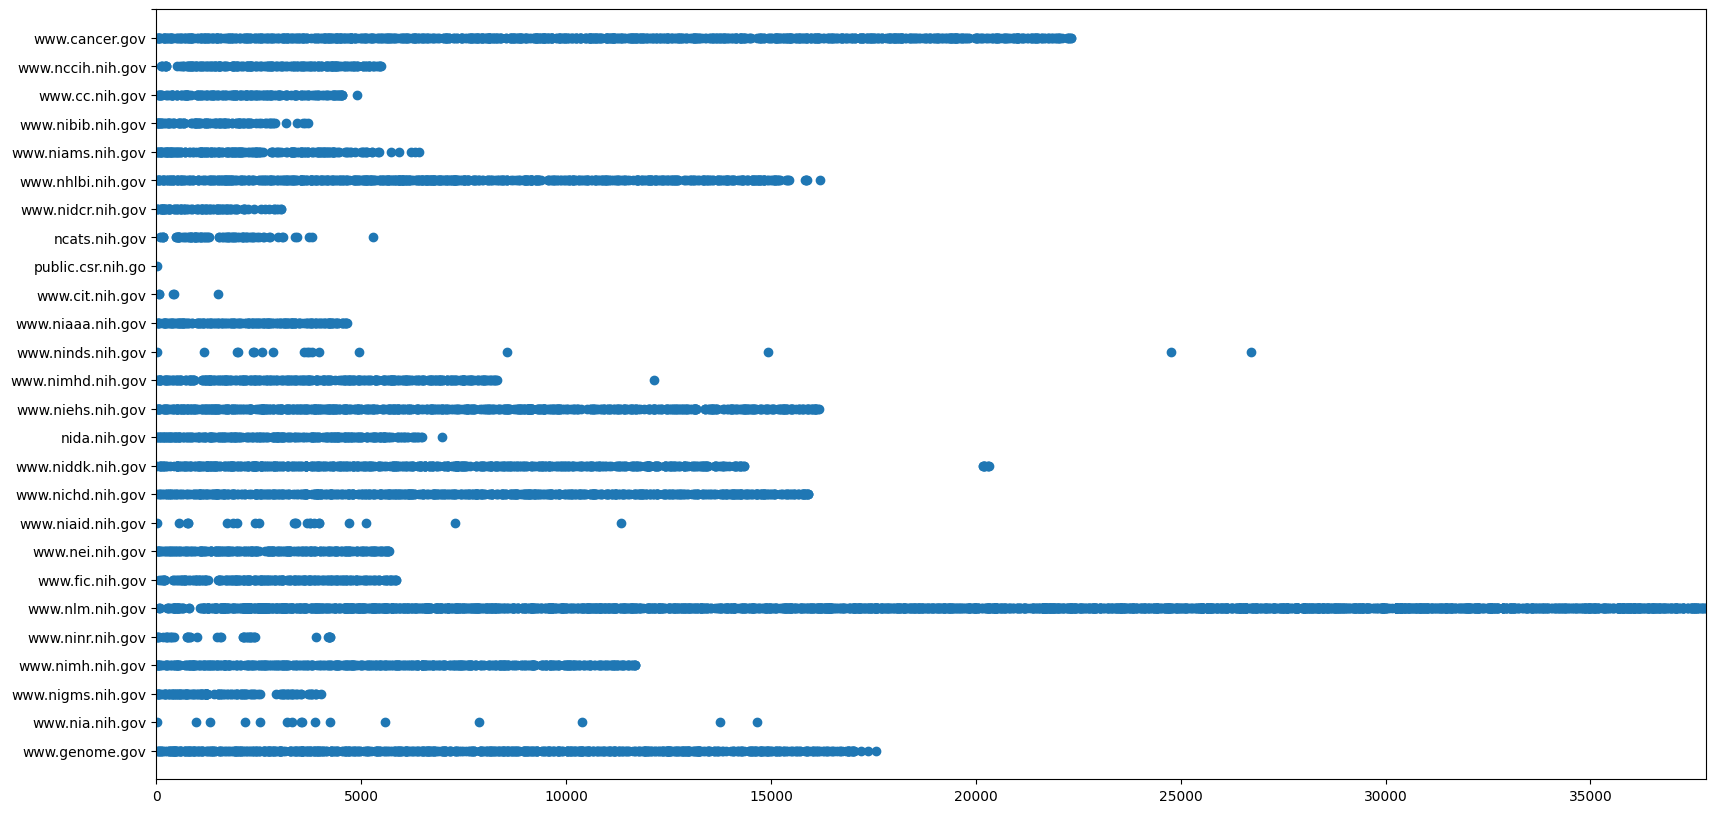

In [27]:
# Put the domains on y, fetches on x
hosts = []
fetches = []
host_names = []

gbq = (GB.select(fn.Distinct(GB.host)))
first_last = dict()
host_id = 1
for uniq_gb in gbq:
    hid = uniq_gb.host_id
    host_name = uniq_gb.host.host
    host_names.append(host_name)
    print(hid, host_name)
    earliest_fetch = GB.select(fn.MIN(GB.last_fetched)).where(GB.host_id == hid).scalar()
    eachq = GB.select().where(GB.host_id == hid)
    
    skip = 10
    skip_counter = 0
    for row in eachq:
        if skip_counter % skip == 0:
            hosts.append(host_id)
            this_seconds = seconds_between(earliest_fetch, row.last_fetched)    
            fetches.append(this_seconds)
        skip_counter = skip_counter + 1
    host_id += 1


plt.rcParams['figure.figsize'] = [20, 10]
fig, ax = plt.subplots()
plt.style.use('_mpl-gallery')
ax.scatter(fetches, hosts)
ax.set(xlim=(0, max(fetches)),
       ylim=(0, max(hosts)), 
       # Doing weird things to make the names look good
       yticks=np.arange(1, len(host_names)+2)
)
# add an empty label so nothing is on top of the graph
ax.set_yticklabels(host_names+[""])

plt.show()